# GEONE - Variogram analysis and kriging for data in 2D (omni-directional)

Interpolate a data set in 2D, using simple or ordinary kriging. Starting from a data set in 2D, the following is done:

- basic exploratory analysis: variogram cloud / variogram rose / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging (OK), simple kriging (SK)
- sequential gaussian simulation (SGS) based on ordinary or simple kriging

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


## Preparation - build a data set in 2D

A data set in 2D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (isotropic) *reference* covariance model in 1D (class `geone.covModel.CovModel1D`), used as omni-directional in 2D.

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [3]:
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('spherical', {'w':9.5, 'r':50}), # elementary contribution (same ranges: isotropic)
    ('nugget', {'w':0.5})                     # elementary contribution
    ], name='ref model (isotropic)')

In [4]:
cov_model_ref

*** CovModel1D object ***
name = 'ref model (isotropic)'
number of elementary contribution(s): 2
elementary contribution 0
    type: spherical
    parameters:
        w = 9.5
        r = 50
elementary contribution 1
    type: nugget
    parameters:
        w = 0.5
*****

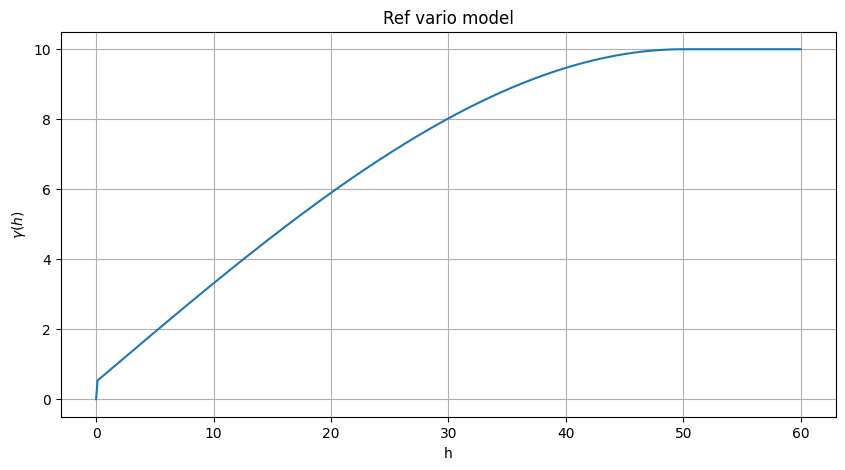

In [5]:
# Plot reference variogram model
plt.figure(figsize=(10,5))
cov_model_ref.plot_model(vario=True)
plt.title('Ref vario model')
plt.show()


Generate a gaussian random field in 2D (see function `geone.grf.grf2D`), and extract data points:

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)

In [6]:
# Simulation grid (domain)
nx, ny = 400, 420  # number of cells
sx, sy = 0.5, 0.5  # cell unit
ox, oy = 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = gn.grf.grf2D(cov_model_ref, (nx, ny), (sx, sy), (ox, oy), nreal=1) 
    # 3d-array of shape 1 x ny x nx

im_ref = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=1, val=ref) # fill image (Img class from geone.img) 

# Extract n points from the reference simulation
n = 50 # number of data points
# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(658)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

In [7]:
# Plot reference simulation and data points
plt.figure(figsize=(10,8))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.title('Ref and data points')
plt.show()

## Start from a data set in 2D

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)

Visualise the data set and the histogram of values.

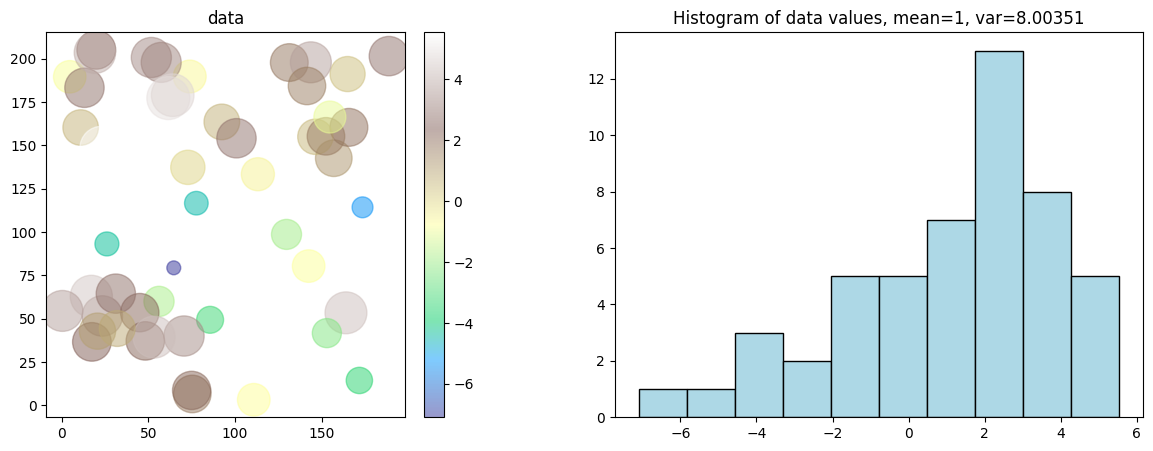

In [8]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
vmin, vmax = np.min(v), np.max(v) # min and max of data values
smin, smax = 100, 1000            # min and max size of points on plot
plot = plt.scatter(x[:,0], x[:,1], c=v, s=smin+(v-vmin)/(vmax-vmin)*(smax-smin), alpha=0.5, cmap='terrain')
gn.customcolors.add_colorbar(plot)
plt.axis('equal')
plt.title('data')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram rose

The function `geone.covModel.variogramExp2D_rose` shows an experimental variogram for a data set in 2D in the form of a rose plot, *i.e.* the lags vectors between the pairs of data points are divided in classes according to length (radius) and angle from the x-axis counter-clockwise (*warning:* opposite sense to the sense given by angle in definition of a covariance model in 2D).

The keyword argument `r_max` allows to specify a maximal length of 2D-lag vector between a pair of data points for being integrated in the variogram rose plot. The number of classes for radius (length) can be specified by the keyword argument `r_ncla`, and the number of classes for angle for half of the whole disk (rose plot is symmetric with respect to the origin) can be specified by the keyword argument `phi_ncla`.

This function can be useful to check a possible anisotropy.

In [9]:
gn.covModel.variogramExp2D_rose(x, v, figsize=(5,5))
plt.show()

/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julien/miniconda3/envs/py313/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


For plotting a variogram rose in a multiple axes figure, proceed as follows.

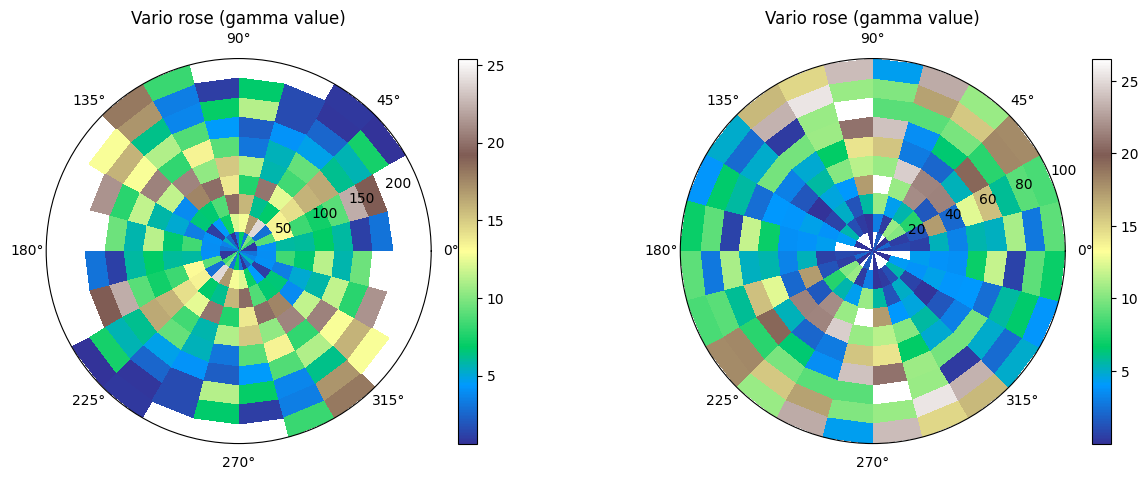

In [10]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1,2,1, projection='polar')
gn.covModel.variogramExp2D_rose(x, v, set_polar_subplot=False)

ax = fig.add_subplot(1,2,2, projection='polar')
gn.covModel.variogramExp2D_rose(x, v, r_max=100, set_polar_subplot=False)

plt.show()

As no anisotropy is visible, an omni-directional covariance / variogram model could be used.

### Omni-directional variogram cloud
The function `geone.covModel.variogramCloud1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

In [11]:
h, g, npair = gn.covModel.variogramCloud1D(x, v)

### Omni-directional experimental variogram
The function `geone.covModel.variogramExp1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

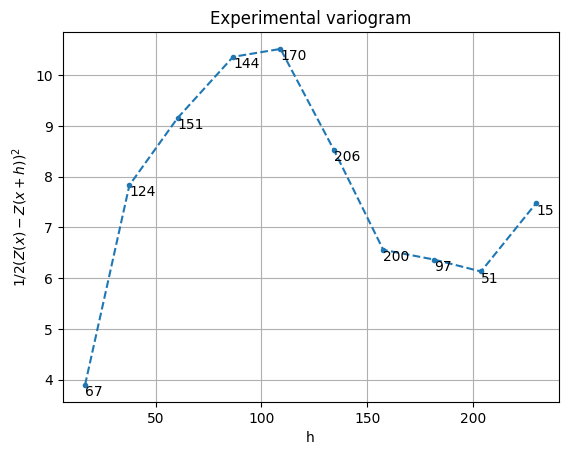

In [12]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 

In [13]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=150, ncla=20)

### Omni-directional model fitting
The function `geone.covModel.covModel1D_fit` is used to fit a covariance model in 1D (class `geone.covModel.CovModel1D`) (see jupyter notebook `ex_vario_analysis_data1D`).

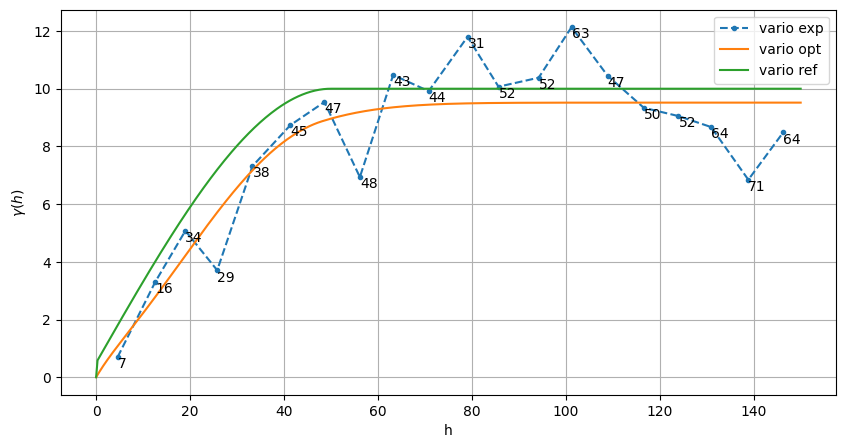

*** CovModel1D object ***
name = ''
number of elementary contribution(s): 4
elementary contribution 0
    type: gaussian
    parameters:
        w = 4.275801892436917
        r = 60.59914771211239
elementary contribution 1
    type: spherical
    parameters:
        w = 4.811228456216264
        r = 48.17956254410442
elementary contribution 2
    type: exponential
    parameters:
        w = 0.43072653821403795
        r = 9.896047971113909
elementary contribution 3
    type: nugget
    parameters:
        w = 0.0002605124942035417
*****

In [14]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
         ], name='')

hmax = 150
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize, hmax=hmax,
                        bounds=([ 0,   0,  0,   0,  0,   0,  0],  # min value for param. to fit
                                [20, 150, 20, 150, 20, 150, 20]), # max value for param. to fit
                        make_plot=False)
plt.figure(figsize=(10,5))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=hmax, label='vario opt') # cov. model in 1D
cov_model_ref.plot_model(vario=True, hmax=hmax, label='vario ref') # cov. model in 1D
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` performs a cross-validation test by leave-one-out (LOO) error. 

For a given a data set (in 2D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

In [15]:
# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige,
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

----- CRPS (negative; the larger, the better) -----
   mean = -1.334
   def. = -0.6611
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.6322
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.08793
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = 0.06768 (should be close to 0)
   std      = 1.129 (should be close to 1)
   skewness = -0.1555 (should be close to 0)
   excess kurtosis = -0.7574 (should be close to 0)


If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued. 

## Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
See notebook `ex_vario_analysis_data1D_1.ipynb`.


Elapsed time: 0.4612 sec


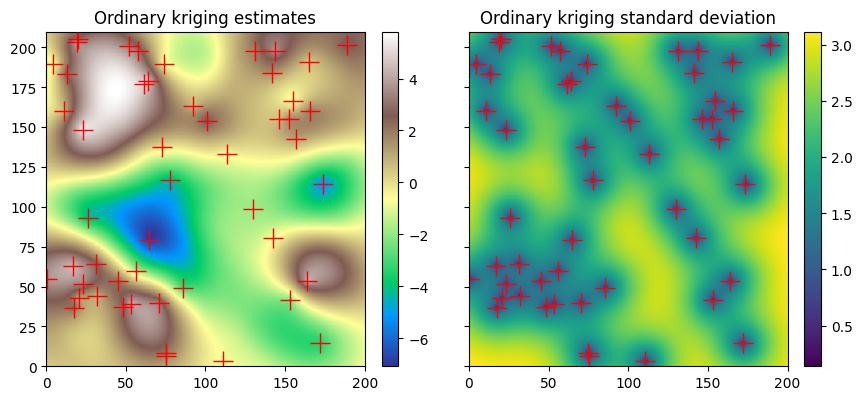

In [16]:
# Define points xu where to interpolate
# ... location of the 2D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*sx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*sy # y-coordinates of points
xxcu, yycu = np.meshgrid(xcu, ycu)
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1))).T # 2-dimensional array of shape nx*ny x 2

# Ordinary kriging
t1 = time.time() # start time
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='ordinary_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.4g} sec')

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))

# Plot
plt.subplots(1,2, figsize=(10,5), sharey=True)

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap='terrain', title='Ordinary kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis', title='Ordinary kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

Elapsed time: 0.4405 sec


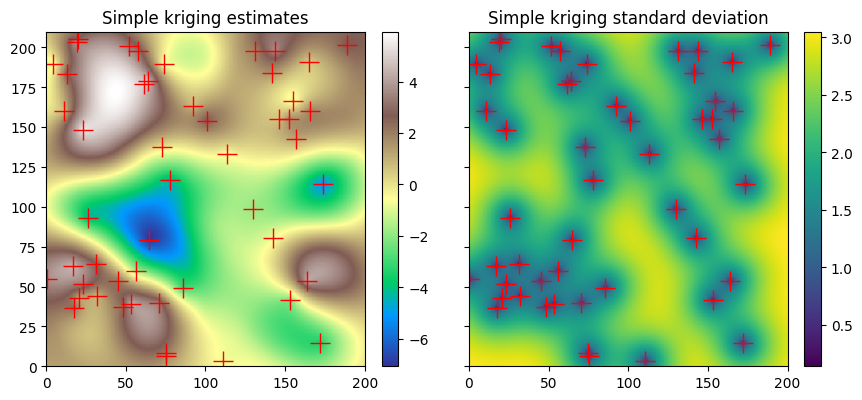

In [17]:
# Define points xu where to interpolate
# ... location of the 2D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*sx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*sy # y-coordinates of points
xxcu, yycu = np.meshgrid(xcu, ycu)
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1))).T # 2-dimensional array of shape nx*ny x 2

# Simple kriging
t1 = time.time() # start time
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.4g} sec')

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))

# Plot
plt.subplots(1,2, figsize=(10,5), sharey=True)

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap='terrain', title='Simple kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis', title='Simple kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

## Simulation based on simple or ordinary kriging: function `geone.covModel.sgs`
See notebook `ex_vario_analysis_data1D_1.ipynb`.


In [18]:
# Define points xu where to simulate
# take less points for simulation
sim_nx, sim_ny = 100, 102 # less points
sim_sx, sim_sy = 2*sx, 2*sy # coarser resolution
sim_ox, sim_oy = 25., 40.
sim_xcu = sim_ox + (np.arange(sim_nx)+0.5)*sim_sx # x-coordinates of points
sim_ycu = sim_oy + (np.arange(sim_ny)+0.5)*sim_sy # y-coordinates of points
sim_xxcu, sim_yycu = np.meshgrid(sim_xcu, sim_ycu)
sim_xu = np.array((sim_xxcu.reshape(-1), sim_yycu.reshape(-1))).T # 2-dimensional array of with two columns

# SGS based on ordinary kriging
nreal = 1
np.random.seed(321)
t1 = time.time() # start time
sim_vu = gn.covModel.sgs(x, v, sim_xu, cov_model_opt, method='ordinary_kriging', nreal=nreal)
# sim_vu:   2-dimensional array of shape (nreal, sim_xu.shape[0]), each row is a realization 
#           (simulated values at locations sim_xu)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Fill image (Img class from geone.img) for view
im_sim = gn.img.Img(sim_nx, sim_ny, 1, sim_sx, sim_sy, 1., sim_ox, sim_oy, 0., nv=nreal, val=sim_vu)

# Plot
plt.subplots(1,2, figsize=(12,5))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_sim, iv=0, cmap='terrain', title='SGS (based on OK), real #0')
#plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_sim, iv=0, cmap='terrain', title='... with conditioning data points')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

1 simul. - elapsed time: 4.709 sec


## Kriging estimation and simulation in a grid
The function above (`gn.covModel.krige` and `gn.covModel.sgs[_mp]`) should not be used for kriging and SGS in a regular grid. Use the dedicated functions (much faster):
- `geone.geosclassicinterface.estimate`: estimation (kriging) in a grid
- `geone.geosclassicinterface.simulate`: simulation (SGS) in a grid
- `geone.grf.krige<d>D`: estimation (kriging) in a `<d>`-dimensional grid
- `geone.grf.grf<d>D`: simulation (SGS) in a `<d>`-dimensional grid

*Note: the functions of the module `geone.grf` are based on "Fast Fourier Transform" and allow for simple kriging only, and do not handle error on data or inequality data.*

*Note: the function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper to run the functions above.*

See notebook `ex_vario_analysis_data1D_1.ipynb`.

## Examples

### Estimation using the function `geone.covModel.krige`

In [19]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.58 sec


### Estimation using the function `geone.grf.krige2D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='fft'`.

In [20]:
t1 = time.time()
im_grf = gn.multiGaussian.multiGaussianRun(
                cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                x=x, v=v,
                mode='estimation', algo='fft', output_mode='img')
# # Or:
# vu_grf, vu_std_grf = gn.grf.krige2D(cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
#                 cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
#                 x=x, v=v)
# im_grf = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((vu_grf, vu_std_grf)))
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krige2D: Computing circulant embedding...
krige2D: embedding dimension: 1024 x 1024
krige2D: Computing FFT of circulant matrix...
krige2D: Computing covariance matrix (rAA) for conditioning locations...
krige2D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige2D: Computing rBA * rAA^(-1)...
krige2D: computing kriging estimates...
krige2D: computing kriging standard deviation ...
Elapsed time: 0.64 sec


### Estimation using the function `geone.geosclassicinterface.estimate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='classic'`.

In [21]:
t1 = time.time()
im_gci = gn.multiGaussian.multiGaussianRun(
                cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                x=x, v=v,
                mode='estimation', algo='classic', output_mode='img',
                method='simple_kriging', use_unique_neighborhood=True,
                nthreads=8)
# # Or:
# estim_gci = gn.geosclassicinterface.estimate(
#                 cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
#                 x=x, v=v,
#                 method='simple_kriging', use_unique_neighborhood=True)
# im_gci = estim_gci['image']
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

estimate: Preprocessing data done: final number of data points : 50, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 3.6 sec


### Plot results of estimation

In [22]:
# Fill images (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))

# Plot
plt.subplots(2,3, figsize=(16,10), sharex=True, sharey=True)

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap='terrain', title="Krig. est. 'gn.covModel.krige'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_grf, iv=0, cmap='terrain', title="Krig. est. 'gn.grf.krige2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,3)
gn.imgplot.drawImage2D(im_gci, iv=0, cmap='terrain', title="Krig. est. 'gn.geosclassicinterface.estimate'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,4)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis', title="Krig. std 'gn.covModel.krige'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_grf, iv=1, cmap='viridis', title="Krig. std 'gn.grf.krige2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_gci, iv=1, cmap='viridis', title="Krig. std 'gn.geosclassicinterface.estimate'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

In [23]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige2D'                     = {}".format(np.ptp(im_krig.val[0] - im_grf.val[0])))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_krig.val[0] - im_gci.val[0])))
print("Peak-to-peak estimation 'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_grf.val[0] - im_gci.val[0])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige2D'                     = {}".format(np.ptp(im_krig.val[1] - im_grf.val[1])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_krig.val[1] - im_gci.val[1])))
print("Peak-to-peak st. dev.   'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_grf.val[1] - im_gci.val[1])))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige2D'                     = 0.30737661539222083
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = 0.5367769238152618
Peak-to-peak estimation 'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = 0.2612659314695387
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige2D'                     = 0.25202512381313064
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = 0.2669320270950835
Peak-to-peak st. dev.   'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = 0.13048658726838092


### Conditional simulation using the function `geone.grf.grf2D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='fft'`.

In [24]:
np.random.seed(293)

t1 = time.time()
nreal = 100
im_sim_grf = gn.multiGaussian.multiGaussianRun(
                    cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                    x=x, v=v,
                    mode='simulation', algo='fft', output_mode='img',
                    nreal=nreal)
# # Or:
# sim_grf = gn.grf.grf2D(
#                     cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
#                     x=x, v=v, 
#                     nreal=nreal)
# im_sim_grf = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=nreal, val=sim_grf)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

grf2D: Preliminary computation...
grf2D: Computing circulant embedding...
grf2D: embedding dimension: 1024 x 1024
grf2D: Computing FFT of circulant matrix...
grf2D: Treatment of conditioning data...
grf2D: Computing covariance matrix (rAA) for conditioning locations...
grf2D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 10 sec


### Conditional simulation using the function `geone.geosclassicinterface.simulate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='classic'`, and specifying the computational resources (`nproc` and `nthreads_per_proc`).

In [25]:
np.random.seed(293)

t1 = time.time()
nreal = 100
im_sim_gci = gn.multiGaussian.multiGaussianRun(
                    cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                    x=x, v=v,
                    mode='simulation', algo='classic', output_mode='img',
                    method='simple_kriging',
                    nreal=nreal,
                    nproc=2, nthreads_per_proc=4)
# # Or:
# sim_gci = gn.geosclassicinterface.simulate(
#                     cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
#                     x=x, v=v, 
#                     method='simple_kriging',
#                     nreal=nreal, 
#                     nproc=4, nthreads_per_proc=4)
# im_sim_gci = sim_gci['image']
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simulate: Preprocessing data done: final number of data points : 50, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (100 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
Elapsed time: 21 sec


### Plot some realizations and compare to the reference simulation

In [26]:
# min and max over all real and ref. sim
im_vmin = min(np.min(im_sim_grf.vmin()), np.min(im_sim_gci.vmin()), im_ref.vmin()[0]) 
im_vmax = max(np.max(im_sim_grf.vmax()), np.min(im_sim_gci.vmax()), im_ref.vmax()[0]) 

# Plot
plt.subplots(2,3, figsize=(16,10), sharex=True, sharey=True)

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_ref, cmap='terrain', vmin=im_vmin, vmax=im_vmax, title='Ref. sim')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_sim_grf, iv=0, cmap='terrain', title="Real. #0 'gn.grf.grf2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,3)
gn.imgplot.drawImage2D(im_sim_gci, iv=0, cmap='terrain', title="Real. #0 'gci.simulate'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,4)
plt.axis('off')

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_sim_grf, iv=1, cmap='terrain', title="Real. #1 'gn.grf.grf2D'")
#plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_sim_gci, iv=1, cmap='terrain', title="Real. #1 'gci.simulate'")
#plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

Note that the nugget weight in the optimal covariance model found is close to zero, whereas in the reference covariance model, its value is 0.5. As a matter of fact, the reference simulation above is a bit more "noisy". To ensure a larger nugget in the optimal covariance model, a minimal bound can be set accordingly for this parameter and passed to the function `geone.covModel.covModel1D_fit`.